<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_8_Pro_v1_%D0%90%D1%83%D0%B4%D0%B8%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRO задание. Вариант 1
Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения. 

Используйте разбивку 900 записей на обучающую выборку и 100 на проверочную



In [ ]:
#Подключаем библиотеки
from google.colab import files
from tensorflow.keras import utils #Для to_categorical
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import plot_model

#Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Подключаем Google drive
from google.colab import drive
drive.mount('/content/drive')
#Базу для ноутбука можно скачать по ссылке
#http://marsyas.info/downloads/datasets.html

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Занятие_8_Обработка аудиосигналов/data')

## Загружаем и параметризируем данные

In [ ]:
import zipfile #Для разорхивации базы

#Разорхивируем архив с базой
#z = zipfile.ZipFile('/content/drive/My Drive/Занятие_8_Обработка аудиосигналов/data/genres.zip', 'r')
#z.extractall()

#Задаём названия жанров
#В архиве названия папок совпадают с названиями жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
#Функция параметризации аудир
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr)) #Частота цветности
  rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #Спектральный центроид
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #Ширина полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Спектральный спад частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты
  
  #Добавляем все параметры в один список
  out = []
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  #По одному добавляем все Мел коэффициенты
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  #for e in chroma_stft:
  #  out.append(np.mean(e))
  
  #Возвращаем получившийся список
  return out

In [ ]:
import time #Для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 60 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=60)
    #Превращаем сигнал в параметризованные данныеБМ и питон ещё нет
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [ ]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
#print(y_train_class)

#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

#Проверяем, что X_train нормировался
#print(X_train[0])

(1000, 26)
(1000, 10)
(1000,)


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1, shuffle=True)

#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 26)
(900,)
(100, 26)
(100,)


## Экспериментируем с простой сетью

### Сделайте совсем простую сеть - один скрытый слой и 10 нейронов

In [ ]:
len(indexes)
X_train.shape[1]

26

In [ ]:
#Число стобцов используемых для обучения данных
indexes = range(0, 26)

input = Input(shape=(X_train.shape[1]))
x = Dense(256*4, activation = 'relu')(input)
x = BatchNormalization()(x)
#x = Dense(256*4, activation = 'relu')(input)
#x = Dropout(0.1)(x)
x = Dense(10, activation='softmax')(x)

model = Model(input, x)

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 40, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=3, min_lr=1e-07, verbose = 1)
Checkpoint = ModelCheckpoint('Audio.h5', monitor = 'val_accuracy', verbose=1, save_best_only=True)

#Обучаем
history = model.fit(X_train[:, indexes], y_train,
                    epochs = 300, batch_size = 30, verbose = 0,
                    validation_data=(X_test[:, indexes], y_test),
                    callbacks = [Checkpoint, reduce_lr, early_stopping])



Epoch 00001: val_accuracy improved from -inf to 0.56000, saving model to Audio.h5

Epoch 00002: val_accuracy did not improve from 0.56000

Epoch 00003: val_accuracy improved from 0.56000 to 0.59000, saving model to Audio.h5

Epoch 00004: val_accuracy did not improve from 0.59000

Epoch 00005: val_accuracy did not improve from 0.59000

Epoch 00006: val_accuracy improved from 0.59000 to 0.64000, saving model to Audio.h5

Epoch 00007: val_accuracy did not improve from 0.64000

Epoch 00008: val_accuracy improved from 0.64000 to 0.69000, saving model to Audio.h5

Epoch 00009: val_accuracy did not improve from 0.69000

Epoch 00010: val_accuracy improved from 0.69000 to 0.70000, saving model to Audio.h5

Epoch 00011: val_accuracy did not improve from 0.70000

Epoch 00012: val_accuracy did not improve from 0.70000

Epoch 00013: val_accuracy did not improve from 0.70000

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00014: val_accuracy improved from 0.7

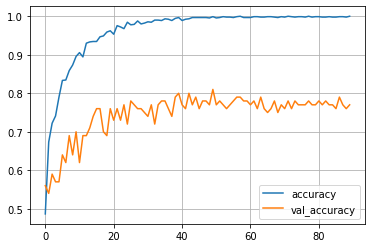

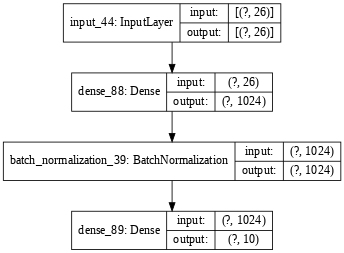

In [ ]:
11#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='val_accuracy')
plt.legend()
plt.grid()
plt.show()

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

In [ ]:
model = load_model('Audio.h5')

#Компилируем сеть
model.compile(optimizer=Adam(lr=1e-3),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-09, verbose = 1)
Checkpoint = ModelCheckpoint('Audio.h5', monitor = 'val_accuracy', verbose=1, save_best_only=True)

#Обучаем
history = model.fit(X_train[:, indexes], y_train,
                    epochs = 100, batch_size = 30, verbose = 1,
                    validation_data=(X_test[:, indexes], y_test),
                    callbacks = [Checkpoint, reduce_lr])

Epoch 1/100
21/30 [====================>.........] - ETA: 0s - loss: 0.0645 - accuracy: 0.9794
Epoch 00001: val_accuracy improved from -inf to 0.73000, saving model to Audio.h5
30/30 [==============================] - 0s 8ms/step - loss: 0.0659 - accuracy: 0.9789 - val_loss: 1.1821 - val_accuracy: 0.7300
Epoch 2/100
25/30 [========================>.....] - ETA: 0s - loss: 0.0732 - accuracy: 0.9760
Epoch 00002: val_accuracy improved from 0.73000 to 0.74000, saving model to Audio.h5
30/30 [==============================] - 0s 4ms/step - loss: 0.0858 - accuracy: 0.9722 - val_loss: 1.0228 - val_accuracy: 0.7400
Epoch 3/100
27/30 [==========================>...] - ETA: 0s - loss: 0.0767 - accuracy: 0.9802
Epoch 00003: val_accuracy improved from 0.74000 to 0.76000, saving model to Audio.h5
30/30 [==============================] - 0s 4ms/step - loss: 0.0744 - accuracy: 0.9800 - val_loss: 1.1361 - val_accuracy: 0.7600
Epoch 4/100
28/30 [===========================>..] - ETA: 0s - loss: 0.0636 

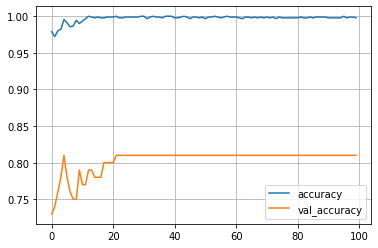

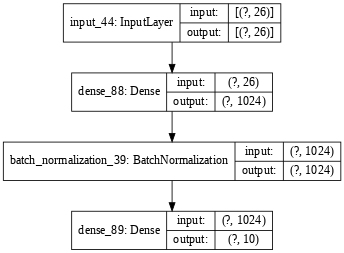

In [ ]:
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='val_accuracy')
plt.legend()
plt.grid()
plt.show()

plot_model(model, dpi=60, show_shapes=True, show_layer_names=True)

# Выводы:
1. Увеличил длину отрезка до 60 сукунд
2. Сначала прошелся RMSprop (тк обеспечивает больший разброс при обучении и больше шансов получить хорошие веса для соранения по чекпоинту), созранил НС
3. Потом добился стабильности с помощью Adam